# SHAP

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import lightgbm as lgb

import shap
from shap import TreeExplainer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython.display import display, HTML # Jupyter環境での表示のため

import joblib
import os

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# Jupyter環境で分子構造をきれいに表示するための設定
IPythonConsole.molSize = (300, 300) # 分子画像のサイズを調整

In [ ]:
# 入力：読み込みたい記述子のタイプを選択
descriptor_type = 'mordred_3d'  # 'rdkit' or 'mordred_2d' or 'mordred_3d'

# ベースのデータ
dataset = pd.read_csv('data/material_data.csv', index_col=0)

# 条件に応じて記述子ファイルを読み込む
if descriptor_type == "rdkit":
    des = pd.read_csv("outputs/descriptors/descriptor_rdkit.csv", index_col=0)
elif descriptor_type == "mordred_2d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_2d.csv", index_col=0)
elif descriptor_type == "mordred_3d":
    des = pd.read_csv("outputs/descriptors/descriptor_mordred_3d.csv", index_col=0)
else:
    raise ValueError(f"未知のdescriptor_type: {descriptor_type}")

# 結合
dataset_full = pd.concat([dataset.reset_index(), des.reset_index(drop=True)], axis=1)
dataset_full = dataset_full.set_index('Material')

# 確認
print(dataset.shape, des.shape, dataset_full.shape)

(1258, 3) (1258, 1480) (1258, 1483)


In [19]:
# TypeとSMILESを消す
dataset_full = dataset_full.drop(['SMILES', 'Type'], axis=1)

# 学習用と予測用に分ける
dataset_train = dataset_full.dropna(subset=['PL']).copy()
dataset_test = dataset_full[dataset_full['PL'].isnull()].copy()

# 予測データのPLは空なので消す
dataset_test = dataset_test.drop('PL', axis=1)

# 1. 両方のデータセットでinfをNaNに置き換える
dataset_train.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. 学習データに基づいて削除すべき列を特定する
#    - NaNを含む列
nan_cols = dataset_train.columns[dataset_train.isnull().any()]
#    - 標準偏差が0の列
zero_std_cols = dataset_train.columns[dataset_train.std() == 0]

#    - 削除する列の全リスト (重複をなくす)
cols_to_drop = nan_cols.union(zero_std_cols)
print(f"学習データに基づいて削除する列の数: {len(cols_to_drop)}")


# 3. 特定した同じ列を「両方のデータセット」から削除する
dataset_train.drop(columns=cols_to_drop, inplace=True)
dataset_test.drop(columns=cols_to_drop, inplace=True, errors='ignore') # テストデータにその列がなくてもエラーにしない

# 4. テストデータに残っているNaNを「学習データの平均値」で埋める
#    まず、学習データから各列の平均値を計算します。
imputation_values = dataset_train.drop('PL', axis=1).mean()

#    計算した平均値を使ってテストデータの欠損値を埋めます。
dataset_test.fillna(imputation_values, inplace=True)

print("\n処理後のshape:")
print(dataset_train.shape, dataset_test.shape)

# 列数が一致していることを確認
if dataset_train.shape[1] - 1 == dataset_test.shape[1]:
    print("✅ 列数が一致しました！ (学習データ: 目的変数分+1)")
else:
    print("❌ 列数が一致していません。")

学習データに基づいて削除する列の数: 261

処理後のshape:
(251, 1220) (1007, 1219)
✅ 列数が一致しました！ (学習データ: 目的変数分+1)


In [20]:
# 最終的な特徴量共通セット
X_train_all = dataset_train.drop(columns='PL')
y_train_all = dataset_train['PL']
X_test = dataset_test.copy()  # PLなし

In [21]:
# モデルタイプを選択, 'rf', 'lgb', 'xgb' のいずれか
model_type = 'lgb'

# モデルとスケーラーを読み込み
base_dir = os.path.join('models', model_type)
model_loaded = joblib.load(os.path.join(base_dir, f'model_{model_type}.pkl'))
X_scaler_loaded = joblib.load(os.path.join(base_dir, 'X_scaler.pkl'))
y_scaler_loaded = joblib.load(os.path.join(base_dir, 'y_scaler.pkl'))

print(f"{model_type} モデルを読み込みました")

lgb モデルを読み込みました


## SHAP

### 学習データでの全体的な傾向確認

In [22]:
# 学習データでSHAP値を可視化

# 標準化する
autoscaled_X_train = X_scaler_loaded.transform(X_train_all)
autoscaled_X_test = X_scaler_loaded.transform(X_test)
# DataFrameに
autoscaled_X_train = pd.DataFrame(autoscaled_X_train, columns=X_train_all.columns, index=X_train_all.index)
autoscaled_X_test = pd.DataFrame(autoscaled_X_test, columns=X_test.columns, index=X_test.index)

# 予測(学習データ)
y_train_pred_scaled = model_loaded.predict(autoscaled_X_train)
y_train_pred = y_scaler_loaded.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_train_pred = pd.DataFrame(y_train_pred, columns=['pred_PL'], index=dataset_train.index)
# 予測(テストデータ)
y_test_pred_scaled = model_loaded.predict(autoscaled_X_test)
y_test_pred = y_scaler_loaded.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_PL'], index=dataset_test.index)

y_train_pred

,pred_PL
Material,
BTD1,526.998548
BTD2,533.134862
BTD3,541.539424
BTD4,587.889071
BTD5,539.333647
...,...
BBTD7,764.921195
BBTD8,720.462048
BBTD9,797.638407


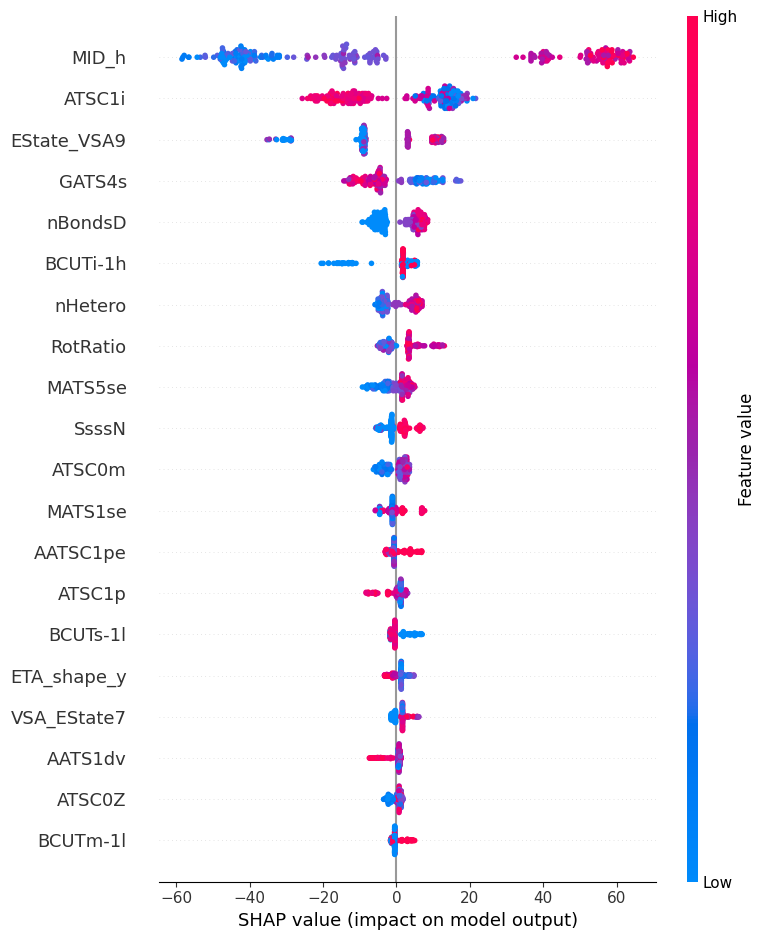

In [23]:
# Explainer, SHAP値の計算、この段階では標準化されている
explainer = TreeExplainer(model_loaded)
shap_values = explainer(autoscaled_X_train)

# yスケーラーの情報を取り出す
y_std = y_scaler_loaded.scale_[0]  # 学習時に使った標準偏差
y_mean = y_scaler_loaded.mean_[0]  # 学習時に使った平均値

# モデルの出力に対する各特徴量の寄与度を元スケールに
shap_values_orig = shap_values.values * y_std
# ベースライン予測値も元のスケールに
base_values_orig = shap_values.base_values * y_std + y_mean

# 新しいSHAP explanationを作成し、SHAPの色付けを元スケールに
shap_values_orig = shap.Explanation(
        values=shap_values_orig,
        base_values=base_values_orig,
        data=X_train_all.values,
        feature_names=X_train_all.columns
    )

# summary_plot可視化
shap.summary_plot(shap_values_orig, show=True)  

- 上から順に重要度の高い特徴量、
- 特徴量値が高い（赤）⇒SHAP値が正（PL値を上げる）、
- 一方特徴量値が高い（赤）⇒SHAP値が負（PL値を下げる）

In [24]:
# ==== 1) 影響度トップkの特徴量を選ぶ ====
k = 3  # 好きな数に
abs_mean_importance = np.abs(shap_values_orig.values).mean(axis=0)  # 各特徴量の|SHAP|平均
top_idx = np.argsort(abs_mean_importance)[::-1][:k]
top_features = [shap_values_orig.feature_names[i] for i in top_idx]
print("Top features:", top_features)

Top features: ['MID_h', 'ATSC1i', 'EState_VSA9']


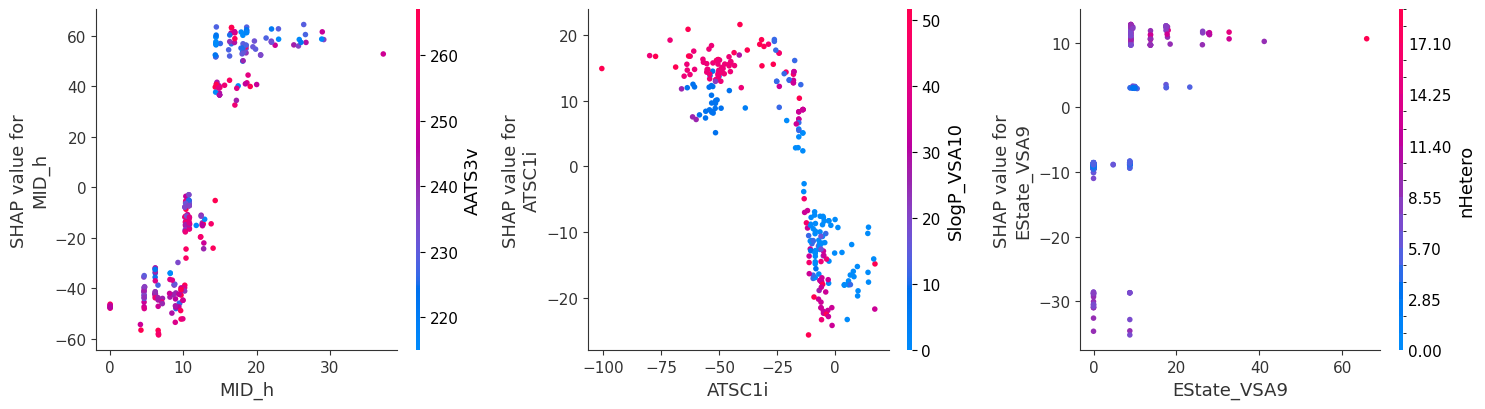

In [25]:
# 上位k個の特徴量を3列のグリッドで並べるために行列数を決める
rows = int(np.ceil(k/3))
cols = min(3, k)
plt.figure(figsize=(5*cols, 4.2*rows))

# 配列で渡す（yスケールへ戻した SHAP 値）
shap_vals_arr = shap_values_orig.values
X_arr = X_train_all.values
feat_names = X_train_all.columns.tolist()

for i, feat in enumerate(top_features, 1):
    ax = plt.subplot(rows, cols, i)
    shap.dependence_plot(
        feat,               # 特徴量名
        shap_vals_arr,      # SHAP値（配列）
        X_arr,              # 元スケールの特徴量（配列）
        feature_names=feat_names,
        interaction_index='auto', # 'auto'にすると自動で相互作用の強い第2特徴量を選択できる、'nHetero'のように特徴量名で指定することも可能。
        ax=ax,              
        show=False
    )

plt.tight_layout()
plt.show()

- x軸：該当特徴量の実際の値
- y軸：その特徴量のSHAP値（＝その特徴量が今回の予測をどれだけ上下に押したか）、絶対値が大きいほど影響が強い     
    プラス→予測を押し上げる     
    マイナス→予測を押し下げる     
- カラーバー：自動で見つけた「相互作用が強い第2特徴量」の値     
    同じxでも色でyが分かれる＝相互作用が効いているサイン

■ MID_h : おおむね右上がり→値が大きいとPLを上げる方向。      
■ ATSC1i : 右下がり→大きいほどPLを下げる     
■ GATS4s : 非線形（ある帯域で一気に下がる）⇒閾値的なふるまい     
■ nBondsD : 段状→離散/段階的な特徴による影響
    

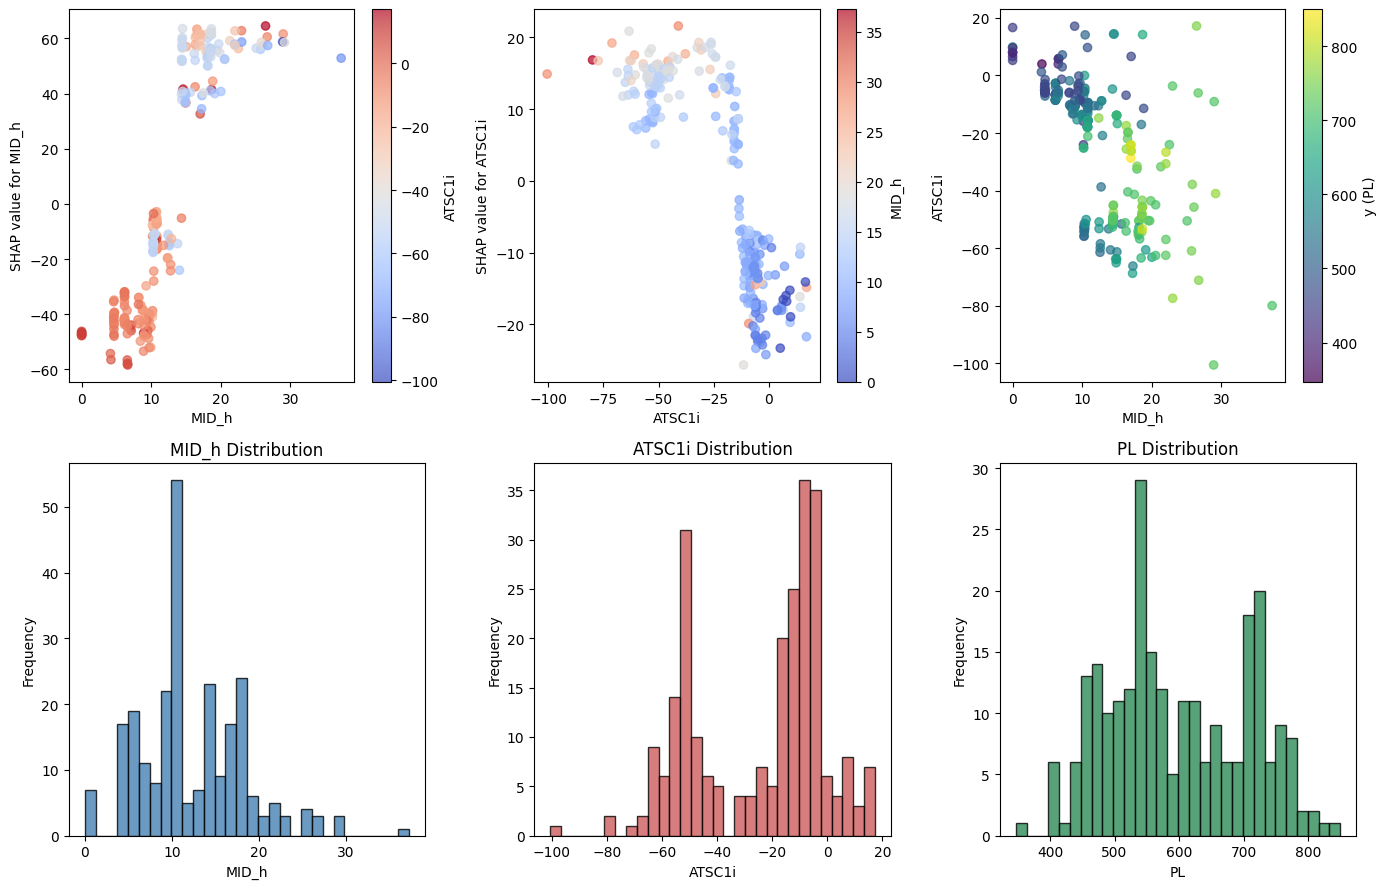

In [26]:
# ==== 事前に用意されているもの ====
# X_train_all : pd.DataFrame (学習X, 元スケール)
# y_train_all : pd.Series or 1d array (学習y, 元スケール)
# shap_values_orig : shap.Explanation
#   - values: (n_samples, n_features)  ※y元スケールに換算済み
#   - data:   X_train_all.values
#   - feature_names: X_train_all.columns

# ==== 3) 上位2特徴の詳見（SHAP散布 & 相関 & 分布） ====
featA, featB = top_features[0], top_features[1]
idxA = list(shap_values_orig.feature_names).index(featA)
idxB = list(shap_values_orig.feature_names).index(featB)

fig = plt.figure(figsize=(14, 9))

# 3-1) SHAP vs featA（色=featB）
ax1 = plt.subplot(2, 3, 1)
sc = ax1.scatter(X_train_all[featA], shap_values_orig.values[:, idxA],
                 c=X_train_all[featB], cmap='coolwarm', alpha=0.7)
ax1.set_xlabel(featA); ax1.set_ylabel(f"SHAP value for {featA}")
cb = plt.colorbar(sc, ax=ax1); cb.set_label(featB)

# 3-2) SHAP vs featB（色=featA）
ax2 = plt.subplot(2, 3, 2)
sc = ax2.scatter(X_train_all[featB], shap_values_orig.values[:, idxB],
                 c=X_train_all[featA], cmap='coolwarm', alpha=0.7)
ax2.set_xlabel(featB); ax2.set_ylabel(f"SHAP value for {featB}")
cb = plt.colorbar(sc, ax=ax2); cb.set_label(featA)

# 3-3) featA × featB（色=y）
ax3 = plt.subplot(2, 3, 3)
sc = ax3.scatter(X_train_all[featA], X_train_all[featB],
                 c=y_train_all, cmap='viridis', alpha=0.7)
ax3.set_xlabel(featA); ax3.set_ylabel(featB)
cb = plt.colorbar(sc, ax=ax3); cb.set_label('y (PL)')

# 3-4) ヒスト: featA
ax4 = plt.subplot(2, 3, 4)
ax4.hist(X_train_all[featA], bins=30, color='steelblue', edgecolor='black', alpha=0.8)
ax4.set_xlabel(featA); ax4.set_ylabel('Frequency'); ax4.set_title(f'{featA} Distribution')

# 3-5) ヒスト: featB
ax5 = plt.subplot(2, 3, 5)
ax5.hist(X_train_all[featB], bins=30, color='indianred', edgecolor='black', alpha=0.8)
ax5.set_xlabel(featB); ax5.set_ylabel('Frequency'); ax5.set_title(f'{featB} Distribution')

# 3-6) ヒスト: y
ax6 = plt.subplot(2, 3, 6)
ax6.hist(y_train_all, bins=30, color='seagreen', edgecolor='black', alpha=0.8)
ax6.set_xlabel('PL'); ax6.set_ylabel('Frequency'); ax6.set_title('PL Distribution')

plt.tight_layout()
plt.show()

### 個別サンプルの詳細分析

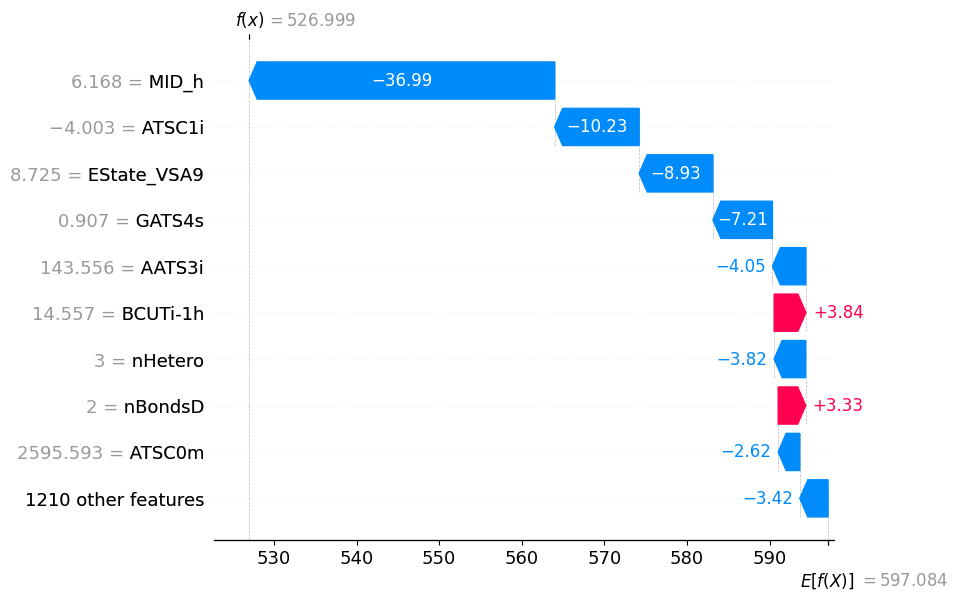

In [27]:
# 3. Waterfall Plot（個別サンプルの予測解釈）
# 特定の1つのサンプルに対する予測が、各特徴量によってどのように構成されているかを示します。
# モデルの出力（Base value + 各特徴量のSHAP値の合計 = 予測値）を視覚的に理解できます。
# 任意のサンプルを選んで
sample_idx = 0  # 最初のサンプル
shap.waterfall_plot(shap_values_orig[sample_idx])

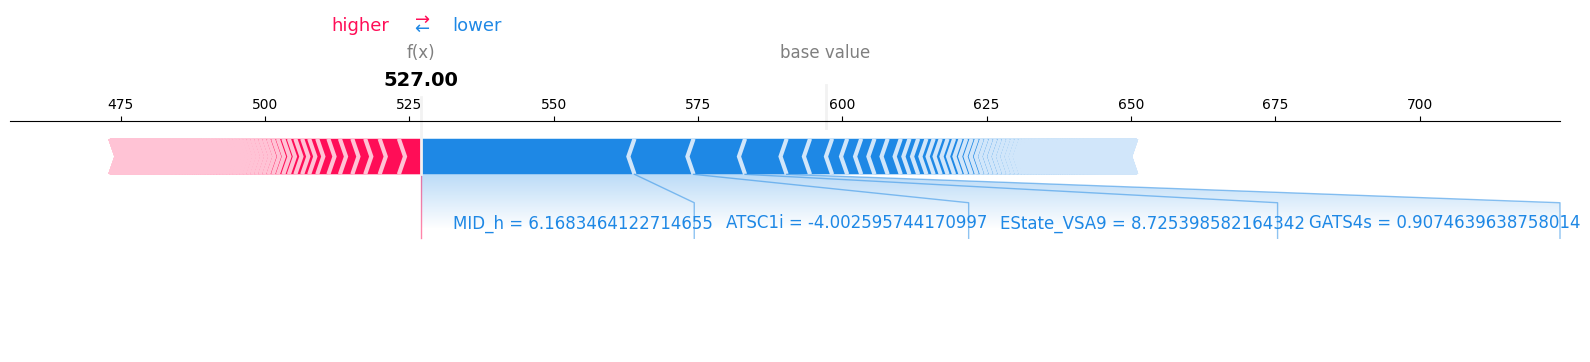

In [28]:
# 5. Force Plot（HTML形式での詳細表示）
shap.force_plot(
    base_values_orig[0],
    shap_values_orig.values[0],
    X_train_all.iloc[0, :],
    feature_names=X_train_all.columns,
    matplotlib=True     # ← 静的描画
)

### テストデータでの予測根拠確認

予測値（テストデータ）平均（元スケール）: 525.78


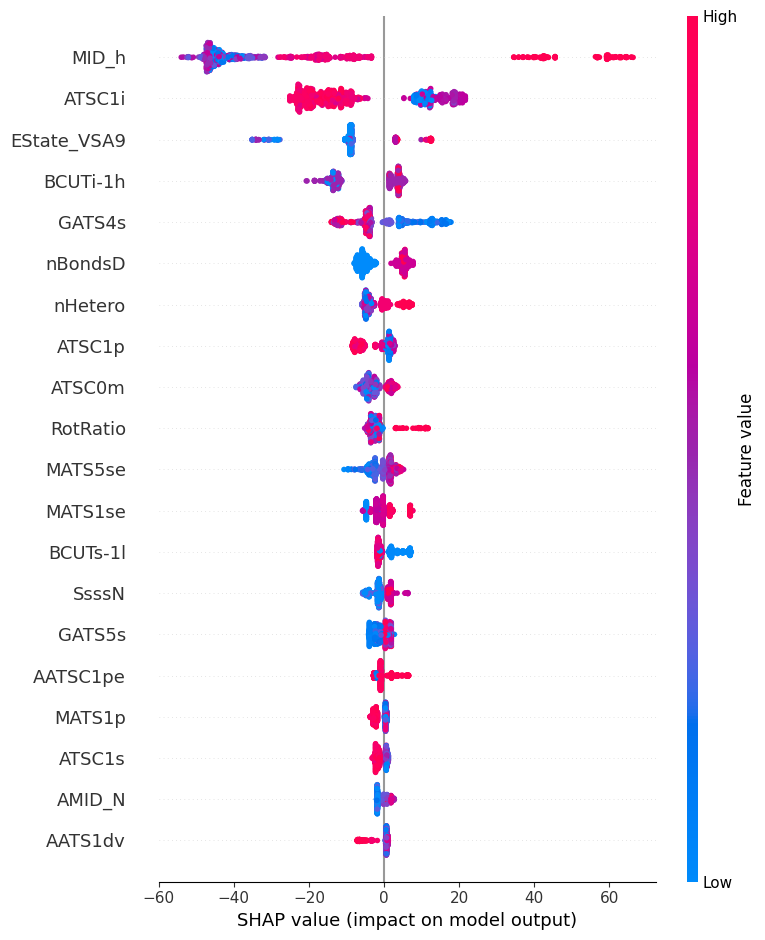

In [29]:
# === 1) テストの SHAP を計算（学習時の explainer をそのまま使う） ===
shap_values_test = explainer(autoscaled_X_test)  # これは y が標準化スケールの SHAP

# 参考: 予測の平均（元スケールでも確認）
y_pred_test_scaled = model_loaded.predict(autoscaled_X_test).reshape(-1, 1)
y_pred_test = y_scaler_loaded.inverse_transform(y_pred_test_scaled)
print('予測値（テストデータ）平均（元スケール）:', float(y_pred_test.mean().round(2)))

# === 2) y の標準化を元スケールへ戻す（train と同じやり方） ===
y_std  = y_scaler_loaded.scale_[0]
y_mean = y_scaler_loaded.mean_[0]

shap_vals_test_orig   = shap_values_test.values * y_std
base_vals_test_orig   = shap_values_test.base_values * y_std + y_mean

# === 3) 元スケールの特徴量で Explanation を作り直す（色付けや軸を元スケールに） ===
shap_test_orig = shap.Explanation(
    values        = shap_vals_test_orig,
    base_values   = base_vals_test_orig,
    data          = X_test.values,              # 元スケール
    feature_names = X_test.columns.tolist()
)

# === 4) Summary plot（元スケールの特徴量で色付け & y も元スケールの SHAP） ===
shap.summary_plot(shap_test_orig, show=True)

Test 上位特徴量: ['MID_h', 'ATSC1i', 'EState_VSA9', 'BCUTi-1h', 'GATS4s', 'nBondsD']


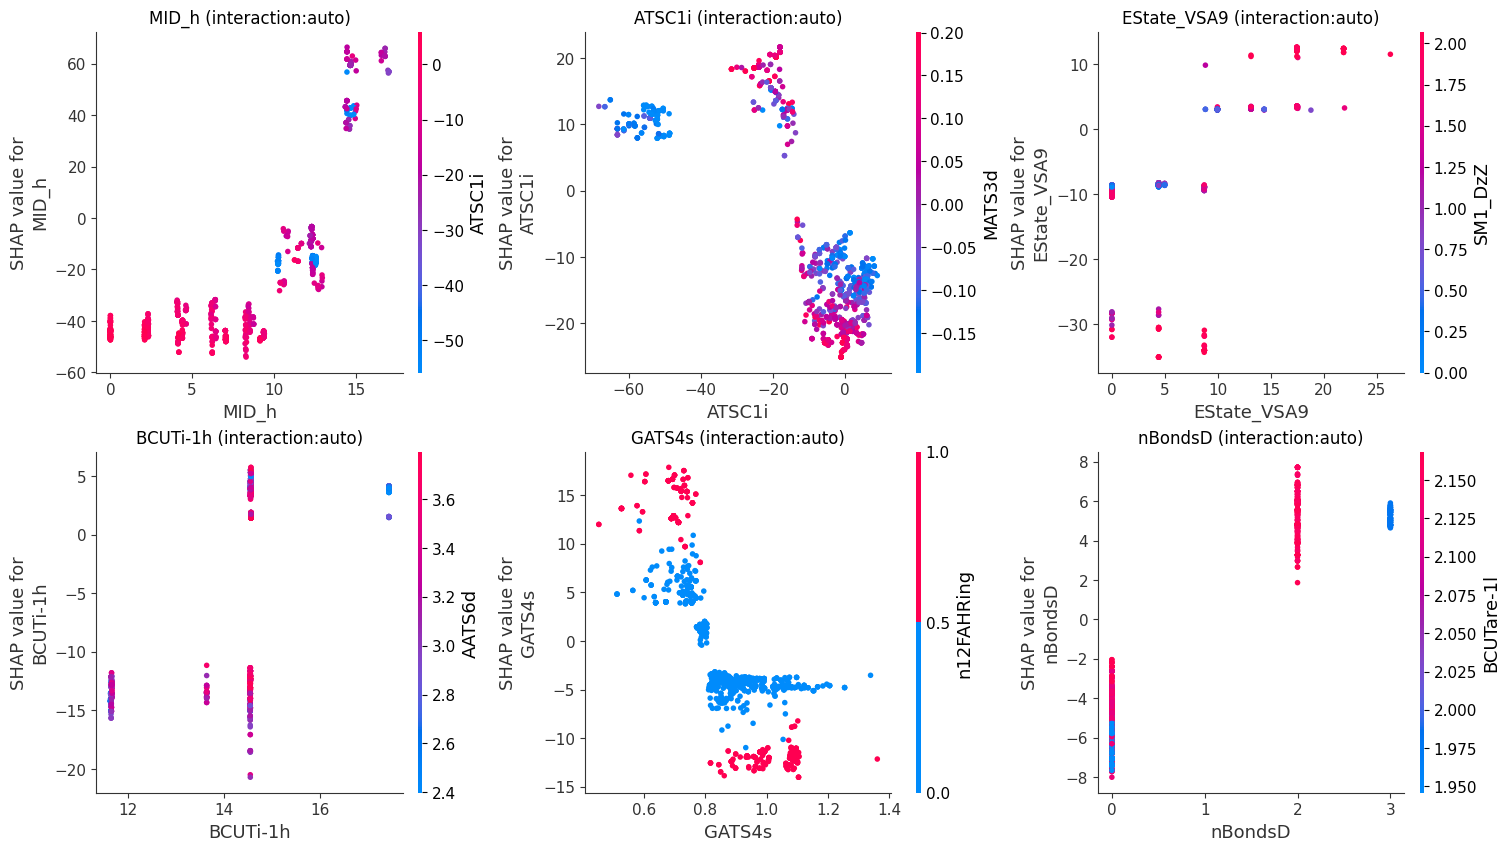

In [30]:
# 上位 k 特徴量をテストの SHAP から抽出
k = 6
fi_test = np.abs(shap_test_orig.values).mean(axis=0)               # |SHAP|平均
top_features = np.array(shap_test_orig.feature_names)[np.argsort(fi_test)[-k:]][::-1]
print("Test 上位特徴量:", top_features.tolist())

rows = int(np.ceil(k/3))
cols = min(3, k)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4.2*rows), constrained_layout=True)
axes = np.array(axes).reshape(-1)

for ax, feat in zip(axes, top_features):
    shap.dependence_plot(
        feat,
        shap_test_orig.values,         # SHAP値
        features=shap_test_orig.data,  # 元特徴量
        feature_names=shap_test_orig.feature_names,
        interaction_index="auto",      # ←色分け不要なら None に
        show=False,
        ax=ax
    )
    ax.set_title(f"{feat} (interaction:auto)")

# 余ったセルを消す（k が rows*cols に満たない場合）
for ax in axes[len(top_features):]:
    ax.axis("off")

plt.show()